In [1]:
 %matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

#  Reflect Tables into SQLAlchemy ORM

In [3]:
 # Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
 # create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

#  Exploratory Precipitation Analysis

In [9]:
# Display the row's columns and data in a dictionary format
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
# Get a list of column names and types for measurement
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Get a list of column names and types for station
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Find the most recent date in the data set. 
latestdatestr = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latestdatestr

latestdatedt = dt.datetime.strptime(latestdatestr[0], '%Y-%m-%d')
querydate = dt.date(latestdatedt.year -1, latestdatedt.month, latestdatedt.day)
querydate

# Perform a query to retrieve the data and precipitation scores
columns_needed = [Measurement.date, Measurement.prcp]
queryresults = session.query(*columns_needed).filter(Measurement.date >= querydate).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_results = pd.DataFrame(queryresults, columns = ['Date', 'Precipitation'])
precipitation_results = precipitation_results.set_index('Date')
precipitation_results
# Sort the dataframe by date
precipitation_results = precipitation_results.sort_values(['Date'], ascending = True)
precipitation_results = precipitation_results.dropna(how = 'any')

precipitation_results.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70


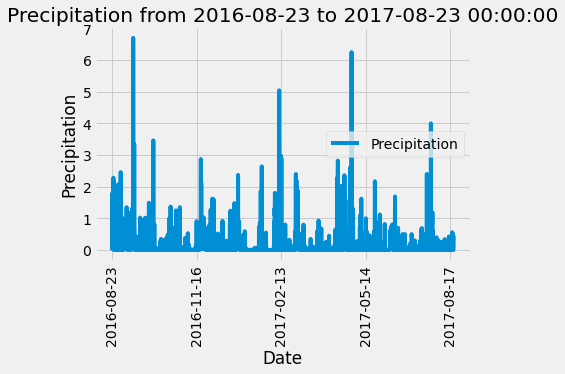

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_results.plot(rot=90)
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.title(f"Precipitation from {querydate} to {latestdatedt}")
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_results.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis


In [15]:
# Design a query to calculate the total number stations in the dataset
number_stations = session.query(Station.id).count()
number_stations

9

In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
count_stations = [Measurement.station,func.count(Measurement.id)]
active_stations = session.query(*count_stations).\
                  group_by(Measurement.station).\
                  order_by(func.count(Measurement.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
mostactivestation = 'USC00519281'
session.query(func.min(Measurement.tobs), 
             func.max(Measurement.tobs),
             func.avg(Measurement.tobs)).filter(Measurement.station == mostactivestation).all()

[(54.0, 85.0, 71.66378066378067)]

<AxesSubplot:ylabel='Frequency'>

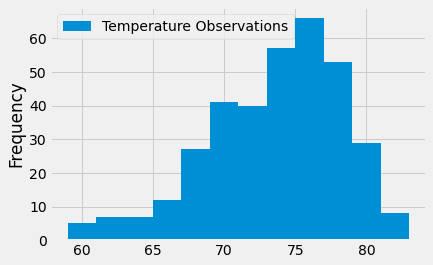

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_columns_needed = active_stations[0][0]
querytempresults = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= querydate).filter(Measurement.station == temp_columns_needed).all()
querytempresults

# Create a DF
querytempresults_df = pd.DataFrame(querytempresults, columns = ['Date', 'Temperature Observations'])
querytempresults_df
# Create histogram
querytempresults_df.plot.hist(bins=12)


#  Close session

In [19]:
 # Close Session
session.close()